# 01b02 RNA Velocity Data

In [ ]:
# default_exp datasets
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

RNA velocity is a high-dimensional vector that predicts the future state of individual cells on a timescale of hours. Authors of RNA Velocity expect it to greatly aid the analysis of developmental lineages and cellular dynamics, particularly in humans.

In this notebook, we have single-cell datasets with RNA velocity information. Functions return 2 $n \times d$ torch tensors and a list. The first tensor contains information of $n$ cells with $d$ features and the second tensor holds the vectors associated with the aforementioned $n$ cells in the same $d$ directions. The list contains the ground truth cell type labels of each of the $n$ cells.

## scvelo Dataset Loaders

Call one of the following and input returned object into `rnavelo` or `rnavelo_pcs` to get data, flows, labels (and n_pcs) in processed form.

- `scvelo.datasets.pancreas()`
- `scvelo.datasets.bonemarrow()`
- `scvelo.datasets.dentategyrus()`
- `scvelo.datasets.dentategyrus_lamanno()`
- `scvelo.datasets.gastrulation_e75()`
- `scvelo.datasets.gastrulation_erythroid()`
- `scvelo.datasets.forebrain()`
- `scvelo.datasets.gastrulation()`
- `scvelo.datasets.pbmc68k()`
- `scvelo.datasets.simulation(n_obs=300, n_vars=None, alpha=None, beta=None, gamma=None, alpha_=None, t_max=None, noise_model='normal', noise_level=1, switches=None, random_seed=0)`

In [ ]:
# export

import scvelo as scv
import torch

def rnavelo_find_cluster_key(adata):
    obs_keys = adata.obs.keys()
    possible_keys = ["clusters", "celltype", "Clusters", "true_t"]
    for key in possible_keys:
        if key in obs_keys:
            return key
    return None

def rnavelo_add_labels(adata):
    cluster_key = rnavelo_find_cluster_key(adata)
    if cluster_key in ["clusters", "celltype"]:
        clusters = adata.obs[cluster_key]
        cluster_set = set(clusters)
        d = {cluster: i for i, cluster in enumerate(cluster_set)}
        labels = torch.tensor([d[cluster] for cluster in clusters])
    
    elif cluster_key in ["Clusters", "true_t"]:
        labels = torch.tensor(adata.obs[cluster_key])
        
    return labels

def rnavelo_preprocess(adata):
    #preprocess data and calculate rna velocity
    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')


def rnavelo(adata):
    rnavelo_preprocess(adata)
    
    X = torch.tensor(adata.X) if type(adata.X) is np.ndarray else torch.tensor(adata.X.todense())
    flows = torch.tensor(adata.layers["velocity"])
    labels = rnavelo_add_labels(adata)
        
    return X, flows, labels

def rnavelo_pcs(adata):
    rnavelo_preprocess(adata)
    
    # calculate pca embedding
    if not(hasattr(adata, "obsm") and "X_pca" in adata.obsm.keys()):
        scv.pp.pca(adata)

    # calculate velocity pca and display pca plot (2 dimensions)
    scv.tl.velocity_graph(adata)
    scv.tl.velocity_embedding(adata, basis='pca', direct_pca_projection=False)
    
    X = torch.tensor(adata.obsm["X_pca"].copy())
    flows = torch.tensor(adata.obsm["velocity_pca"].copy())
    labels = rnavelo_add_labels(adata)
    n_pcs = X.shape[1]
    
    return X, flows, labels, n_pcs

def rnavelo_plot_pca(adata, ax=None, show=True):
    rnavelo_pcs(adata)
    cluster_key = rnavelo_find_cluster_key(adata)
    scv.pl.velocity_embedding_stream(adata, basis='pca', color=cluster_key, ax=ax, show=show)

## Examples

### Bone Marrow Dataset

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:01:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


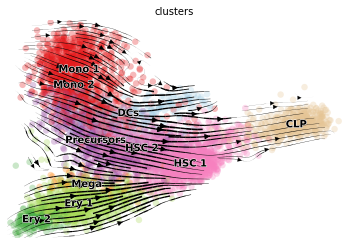

In [ ]:
adata = scv.datasets.bonemarrow()
rnavelo_plot_pca(adata)

## Pancreas Datasets

In [ ]:
adata = scv.datasets.pancreas()
X, flows, labels = rnavelo(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
X2, flows2, labels2, n_pcs = rnavelo_pcs(adata)

computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:26) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:01:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


In [ ]:
print(X.shape)
print(flows.shape)
print(labels.shape)

print(X2.shape)
print(flows2.shape)
print(labels2.shape)
print(n_pcs)

torch.Size([3696, 27998])
torch.Size([3696, 27998])
torch.Size([3696])
torch.Size([3696, 50])
torch.Size([3696, 50])
torch.Size([3696])
50


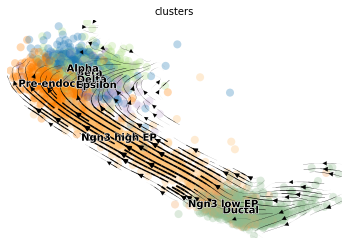

In [ ]:
rnavelo_plot_pca(adata)

## Dentategyrus

In [ ]:
adata = scv.datasets.dentategyrus()
X, flows, labels = rnavelo(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
X, flows, labels, n_pcs = rnavelo_pcs(adata)

computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:30) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


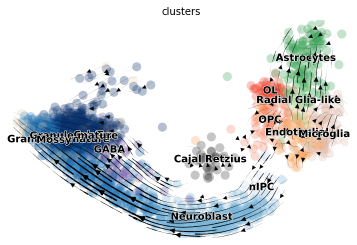

In [ ]:
rnavelo_plot_pca(adata)